# Libraries

In [ ]:
%matplotlib inline
from collections.abc import Iterable, Sequence
from collections import Counter
from collections import defaultdict
import copy
import enum
import time
from datetime import datetime
import calendar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
import re
import nltk

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline

import seaborn

# Load data

In [ ]:
#####################
# Utility Functions #
#####################

def get_dataframes_from_csv(path_to_features, path_to_targets=None):
    """
    Get Pandas DataFrames for features and targets
    """
    features_dataframe = pd.read_csv(path_to_features, encoding="utf8")
    
    if not path_to_targets:
        return features_dataframe
    
    targets_dataframe = pd.read_csv(path_to_targets)
    return features_dataframe, targets_dataframe

def get_features_from_dataframe(features_dataframe) -> tuple[list, list, list, list]:
    """
    Get all feature columns as lists from DataFrame
    """
    usernames = list(features_dataframe.author)
    comments = list(features_dataframe.body)
    subreddits = list(features_dataframe.subreddit)
    created_utc = list(features_dataframe.created_utc)
    return usernames, comments, subreddits, created_utc

def get_targets_from_dataframe(features_dataframe, targets_dataframe) -> list[int]:
    """
    Get targets as lists from DataFrame
    """
    targets_dictionary : dict[str, int] = dict(zip(targets_dataframe.author, 
                                                   targets_dataframe.gender))
    targets : list[int] = list(map(lambda a: targets_dictionary[a], features_dataframe.author))
    return targets

In [ ]:
#############
# Execution #
#############

training_features_dataframe, training_targets_dataframe = get_dataframes_from_csv("data/train_data.csv", 
                                                                             "data/train_target.csv")
training_comments : list[str] = list(training_features_dataframe.body)
training_targets : list[int] = get_targets_from_dataframe(training_features_dataframe, 
                                                          training_targets_dataframe)

print(training_comments[:3])
print(training_targets[:3])

["I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.", "Thanks. I made it up, that's how I got over my first heart break. ", "Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)\n\nMaybe I'm just a bad player... But every time I faced one on my first playthrough, all my pawns ended up getting to 0 HP at least once and I could barely get an attack in once it started berserking."]
[0, 1, 0]


# Group by author

In [ ]:
#####################
# Utility Functions #
#####################

def group_dataframe_by_author(features_dataframe):
    """
    Group all features in the dataframe by author.
    """
    return features_dataframe.groupby('author', as_index=False).agg({
                         'subreddit':join_strings, 
                         'body':join_strings, 
                         'created_utc': join_ints})

def join_strings(x : Iterable[str]):
    """
    Join all elements of a list/iterable of strings with a white-space in-between.
    """
    return ' '.join(x)

def join_ints(x : Iterable[int]):
    """
    Join all elements of a list/iterable of ints with a comma in-between.
    """
    return ','.join(map(lambda i: str(i), x))


In [ ]:
#############
# Execution #
#############

training_features_dataframe_groupby_author = group_dataframe_by_author(training_features_dataframe)

training_comments_groupby_author : list[str] = list(training_features_dataframe_groupby_author.body)
training_targets_groupby_author : list[int] = get_targets_from_dataframe(training_features_dataframe_groupby_author, training_targets_dataframe)

print(training_features_dataframe_groupby_author.head())
print(training_comments_groupby_author[:1])
print(training_targets_groupby_author[:5])

           author                                          subreddit  \
0          -Jared   AskReddit tall pics StarWars AskReddit AskReddit   
1         -Peeter                                             gainit   
2        -evasian  MouseReview MechanicalKeyboards jailbreak jail...   
3         -rubiks  AskWomen AskWomen AskWomen AskWomen AskWomen A...   
4  -true_neutral-                    mildlyinteresting todayilearned   

                                                body  \
0  Neil Diamond - Sweet Caroline +1 on the chirop...   
1                         Just read the FAQ, really.   
2  I just received my Deathadder Black Edition ye...   
3  AlunaGeorge - Best Be Believing\nArctic Monkey...   
4  &gt; Urban Ears Metis\n\nYMMV. I have had thre...   

                                         created_utc  
0  1390189315.0,1390189970.0,1390492589.0,1390496...  
1                                       1389962703.0  
2  1388678755.0,1388688144.0,1389891805.0,1389892...  
3  1389194

# Generate Part-Of-Speech data

In [83]:
#####################
# Utility Functions #
#####################

def get_pos_tag_count(text : str) -> dict[str, float]:
    lower_case = text.lower()
    tokens = nltk.word_tokenize(lower_case)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word, tag in tags)
    total = sum(counts.values(), 0.0)
    normalized_counts = {k: v / total for k, v in counts.items()}
    return normalized_counts

###################
# Utility Classes #
###################

class PosTagVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom vectorizer.
    Transforms a list of strings in a matrix of Part-Of-Speech counts.
    Uses DictVectorizer by default.
    """
    def __init__(self, vectorizer=None):
        super().__init__()
        if vectorizer:
            self.vectorizer = vectorizer
        else:
            self.vectorizer = DictVectorizer()
    
    def fit(self, X, y=None):
        self.vectorizer.fit(map(get_pos_tag_count, X))
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.transform(map(get_pos_tag_count, X))
    
    def get_feature_names_out(self):
        return self.vectorizer.get_feature_names_out()

In [92]:
#############
# Execution #
#############

pos_vectorizer = PosTagVectorizer()
print(pos_vectorizer.fit_transform(["hi i am matteo!!!"]))
print(pos_vectorizer.get_feature_names_out())

  (0, 0)	0.42857142857142855
  (0, 1)	0.42857142857142855
  (0, 2)	0.14285714285714285
['.' 'NN' 'VBP']


# Generate subreddit data

In [93]:
#####################
# Utility Functions #
#####################

def get_subreddit_count(subreddits : str) -> dict[str, int]:
    subs = subreddits.split()
    counts = Counter(subreddit for subreddit in subs)
    return counts

###################
# Utility Classes #
###################

class SubredditVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom vectorizer.
    Transforms a list of strings of subreddits (separated by whitespace) in a matrix of Part-Of-Speech subreddit counts.
    Uses DictVectorizer by default.
    """
    def __init__(self, vectorizer=None):
        super().__init__()
        if vectorizer:
            self.vectorizer = vectorizer
        else:
            self.vectorizer = DictVectorizer()
    
    def fit(self, X, y=None):
        self.vectorizer.fit(map(get_subreddit_count, X))
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.transform(map(get_subreddit_count, X))
    
    def get_feature_names_out(self):
        return self.vectorizer.get_feature_names_out()

In [97]:
#############
# Execution #
#############

subreddit_vectorizer = SubredditVectorizer()
print(subreddit_vectorizer.fit_transform(["AskWomen AskWomen AskWomen AskWomen AskWomen mildlyinteresting jailbreak", "jailbreak motors"]))
print(subreddit_vectorizer.get_feature_names_out())

  (0, 0)	5.0
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
['AskWomen' 'jailbreak' 'mildlyinteresting' 'motors']


# Generate timestamp data

In [167]:
#####################
# Utility Functions #
#####################

def to_date(epoch):
    return datetime.utcfromtimestamp(epoch)

def to_slug(epoch):
    date = to_date(float(epoch))
    ordinal = date.weekday()*24 + date.hour
    weekday = calendar.day_name[date.weekday()]
    hour = date.hour
    return f'{ordinal:03}_{weekday.upper()}_{hour:02}'

def get_comment_time_count(comment_times : str) -> dict[str, int]:
    times = comment_times.split(',')
    slugged_times = map(to_slug, times)
    counts = Counter(time for time in slugged_times)
    return counts
    
###################
# Utility Classes #
###################

class EpochVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom vectorizer.
    Transforms a list of strings of epoch times (assuming UTC, separated by commas) in a matrix of counts binned by weekday+hour (bins are sorted chronologically).
    Uses DictVectorizer by default.
    """
    def __init__(self, vectorizer=None):
        super().__init__()
        if vectorizer:
            self.vectorizer = vectorizer
        else:
            self.vectorizer = DictVectorizer(sort=True)
    
    def fit(self, X, y=None):
        self.vectorizer.fit(map(get_comment_time_count, X))
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.transform(map(get_comment_time_count, X))
    
    def get_feature_names_out(self):
        return self.vectorizer.get_feature_names_out()

In [ ]:
#############
# Execution #
#############

epoch_vectorizer = EpochVectorizer()
print(epoch_vectorizer.fit_transform(training_features_dataframe_groupby_author.created_utc))
print(training_set_dataframe_groupby_author.author[np.ndarray.argmax(epoch_vectorizer.transform(training_features_dataframe_groupby_author.created_utc).toarray().T, axis=1)])

  (0, 3)	2.0
  (0, 87)	1.0
  (0, 89)	1.0
  (0, 92)	1.0
  (0, 93)	1.0
  (1, 108)	1.0
  (2, 39)	1.0
  (2, 61)	1.0
  (2, 63)	2.0
  (2, 66)	1.0
  (2, 88)	1.0
  (2, 89)	2.0
  (2, 90)	1.0
  (2, 93)	1.0
  (3, 63)	1.0
  (3, 86)	3.0
  (3, 98)	2.0
  (3, 109)	1.0
  (3, 111)	1.0
  (3, 148)	1.0
  (4, 72)	1.0
  (4, 100)	1.0
  (5, 4)	1.0
  (5, 22)	2.0
  (5, 26)	1.0
  :	:
  (4996, 66)	1.0
  (4996, 67)	2.0
  (4996, 68)	1.0
  (4996, 70)	4.0
  (4996, 88)	3.0
  (4996, 89)	3.0
  (4996, 90)	1.0
  (4996, 91)	1.0
  (4996, 98)	3.0
  (4996, 103)	1.0
  (4996, 105)	1.0
  (4996, 111)	2.0
  (4996, 114)	1.0
  (4996, 117)	4.0
  (4996, 119)	1.0
  (4996, 121)	1.0
  (4996, 136)	1.0
  (4996, 164)	1.0
  (4997, 20)	2.0
  (4997, 23)	2.0
  (4998, 26)	1.0
  (4998, 27)	1.0
  (4998, 28)	1.0
  (4998, 119)	1.0
  (4999, 82)	2.0
['000_MONDAY_00' '001_MONDAY_01' '002_MONDAY_02' '003_MONDAY_03'
 '004_MONDAY_04' '005_MONDAY_05' '006_MONDAY_06' '007_MONDAY_07'
 '008_MONDAY_08' '009_MONDAY_09' '010_MONDAY_10' '011_MONDAY_11'
 '012_MONDA

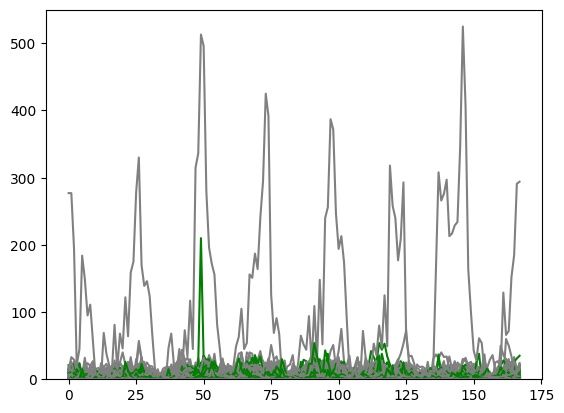

In [234]:
#########
# Plots #
#########
colormap = np.array(['gray', 'g'])
colors = colormap[training_targets_groupby_author]

lines = plt.plot(np.array(range(168)).T,epoch_vectorizer.transform(training_features_dataframe_groupby_author.created_utc).toarray().T)
ax = plt.gca()
ax.set_ylim([0, 550])

for idx, color in enumerate(colors):
    lines[idx].set_color(color)
plt.show()

# Generate username data

In [55]:
#####################
# Utility Functions #
#####################

def get_character_count(username : str) -> dict[str, int]:
    counts = Counter(char for char in username)
    return counts
    
###################
# Utility Classes #
###################

class UsernameVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom vectorizer.
    Transforms a list of usernames in a matrix of character counts (case sensitive).
    Uses DictVectorizer by default.
    """
    def __init__(self, vectorizer=None):
        super().__init__()
        if vectorizer:
            self.vectorizer = vectorizer
        else:
            self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1), lowercase=False)
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X, y=None):
        #transformed = self.vectorizer.transform(X)
        #return sparse.hstack(transformed, transformed.sum(axis=1))[:,None]
        return sparse.hstack([self.vectorizer.transform(X),self.vectorizer.transform(X).sum(axis = 1)])


    
    def get_feature_names_out(self):
        return [*self.vectorizer.get_feature_names_out(), 'length']

In [56]:
#############
# Execution #
#############

username_vectorizer = UsernameVectorizer()
print(username_vectorizer.fit_transform(training_features_dataframe_groupby_author.author[1:5000]))
print(username_vectorizer.get_feature_names_out())

  (0, 0)	1
  (0, 26)	1
  (0, 42)	3
  (0, 55)	1
  (0, 57)	1
  (1, 0)	1
  (1, 38)	2
  (1, 42)	1
  (1, 46)	1
  (1, 51)	1
  (1, 56)	1
  (1, 59)	1
  (2, 0)	1
  (2, 39)	1
  (2, 46)	1
  (2, 48)	1
  (2, 55)	1
  (2, 56)	1
  (2, 58)	1
  (3, 0)	2
  (3, 37)	1
  (3, 38)	1
  (3, 42)	2
  (3, 49)	1
  (3, 51)	1
  :	:
  (4974, 64)	5
  (4975, 64)	14
  (4976, 64)	6
  (4977, 64)	15
  (4978, 64)	5
  (4979, 64)	6
  (4980, 64)	6
  (4981, 64)	3
  (4982, 64)	9
  (4983, 64)	6
  (4984, 64)	12
  (4985, 64)	4
  (4986, 64)	6
  (4987, 64)	5
  (4988, 64)	9
  (4989, 64)	12
  (4990, 64)	15
  (4991, 64)	4
  (4992, 64)	6
  (4993, 64)	7
  (4994, 64)	5
  (4995, 64)	5
  (4996, 64)	7
  (4997, 64)	4
  (4998, 64)	7
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z

# Generate CV-TFIDF comment data

In [98]:
###################
# Utility Classes #
###################

class TokenPatterns(enum.Enum):
    """
    Exposes useful regex patterns for CountVectorizer and TfIdfVectorizer
    """
    TKN_ALL_BUT_WHITESPACE = r'[^\s]+'
    """Match all groups of chars separated by whitespaces"""

    TKN_3_OR_MORE_ALPHA = '(?u)\\b[A-Za-z]{3,}'
    """Match whole words of alphabetical chars of three or more chars"""

    TKN_1_OR_MORE_ALPHA = '(?u)\\b[A-Za-z]{1,}'
    """Match whole words of alphabetical chars of one or more chars"""

# Data Clean-up

# Latent Semantic Analysis

# Fit with different estimators

## Pipeline

## Grid Search and Cross-Validation

In [ ]:
# grid search over:
# min_df, max_df
# feature selection: truncatedSVD 
# different models: GradientBoostingClassifier, HistogramBoostingClass, RandomForest, LogisticReg, SVM with RBF, Naive Bayes
# max_abs_scaler, standardscaler, tf-idf normalization


# Ensemble classifier

# Evaluate on Test Set